In [ ]:
!pip install noisereduce

In [ ]:
!pip install librosa==0.9.1

In [3]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import layers, models, utils
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import img_to_array, array_to_img
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.models import load_model

%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model

In [4]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Alphabet.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
# Function to extract log mel spectrogram from audio file
def extract_mel_spectrogram(file_path, n_mels=128, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec


# Function to extract log mel spectrogram from audio file and resize it
def extract_and_resize(file_path, n_mels=128, hop_length=512, target_size=(224, 224)):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    log_mel_spec_resized = np.resize(log_mel_spec, target_size)
    # Add batch and channel dimensions
    log_mel_spec_resized = log_mel_spec_resized[np.newaxis, ..., np.newaxis]
    return log_mel_spec_resized

In [6]:
# Function to load audio data, labels, and decoded labels
def load_data(data_dir):
    data = []
    labels = []
    label_encoder = LabelEncoder()

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                if file.endswith(".wav"):  # Assuming audio files are in WAV format
                    mel_spec = extract_mel_spectrogram(file_path)
                    data.append(mel_spec)
                    labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    labels_encoded = label_encoder.fit_transform(labels)
    labels_decoded = label_encoder.inverse_transform(labels_encoded)

    return data, labels_encoded, labels_decoded

In [7]:
 # Load data
data_dir = "../content/Alphabet"
data, labels, decoded_labels = load_data(data_dir)

Streaming output truncated to the last 5000 lines.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, hop_length=hop_length)
<ipython-input-5-a19d7def9bc1>:4: FutureWarning: Pass y=[-2.4414062e-04  2.7465820e-04 -3.0517578e-05 ... -9.1552734e-05
 -7.0190430e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, hop_length=hop_length)
<ipython-input-5-a19d7def9bc1>:4: FutureWarning: Pass y=[-0.00039673 -0.00067139 -0.00137329 ...  0.00021362  0.00112915
 -0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, hop_length=hop_length)
<ipython-input-5-a19d7def9bc1>:4: FutureWarning: Pass y=[-2.4414062e-04  2.74658

In [8]:
# Train-test split
X_train_paths, X_test_paths, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [9]:
X_train_paths.shape
#y_train.shape

(17760, 128, 32)

In [10]:
# Reshape data for CNN input
X_train = X_train_paths[..., np.newaxis]
X_test = X_test_paths[..., np.newaxis]

In [11]:
X_train.shape

(17760, 128, 32, 1)

# Model

In [12]:
# Build CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 30, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 64)                7

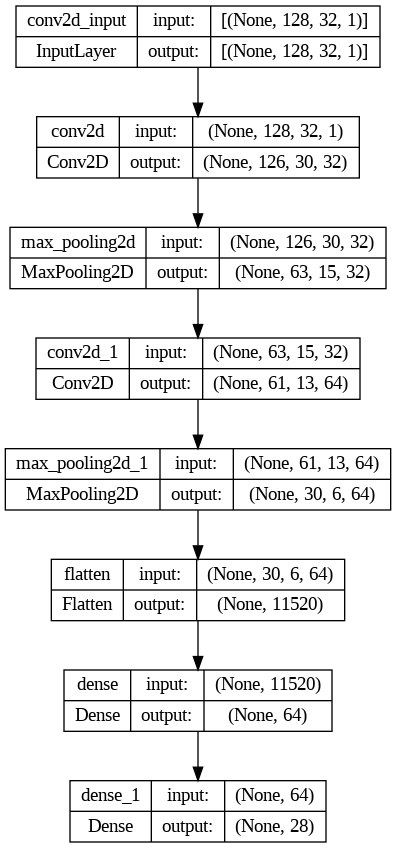

In [13]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [14]:
# Train the model
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/30
555/555 [==============================] - 7s 6ms/step - loss: 2.2692 - accuracy: 0.3851 - val_loss: 1.2165 - val_accuracy: 0.6248
Epoch 2/30
 27/555 [>.............................] - ETA: 2s - loss: 1.2231 - accuracy: 0.6354

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


555/555 [==============================] - 3s 5ms/step - loss: 0.9989 - accuracy: 0.6889 - val_loss: 0.7973 - val_accuracy: 0.7453
Epoch 3/30
555/555 [==============================] - 3s 5ms/step - loss: 0.6506 - accuracy: 0.7926 - val_loss: 0.8032 - val_accuracy: 0.7480
Epoch 4/30
555/555 [==============================] - 3s 5ms/step - loss: 0.4837 - accuracy: 0.8418 - val_loss: 0.5228 - val_accuracy: 0.8408
Epoch 5/30
555/555 [==============================] - 3s 5ms/step - loss: 0.3542 - accuracy: 0.8829 - val_loss: 0.4407 - val_accuracy: 0.8550
Epoch 6/30
555/555 [==============================] - 3s 5ms/step - loss: 0.2946 - accuracy: 0.9022 - val_loss: 0.4239 - val_accuracy: 0.8615
Epoch 7/30
555/555 [==============================] - 3s 5ms/step - loss: 0.2780 - accuracy: 0.9065 - val_loss: 0.4024 - val_accuracy: 0.8849
Epoch 8/30
555/555 [==============================] - 3s 5ms/step - loss: 0.1989 - accuracy: 0.9350 - val_loss: 0.4249 - val_accuracy: 0.8590
Epoch 9/30
555/55

In [15]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

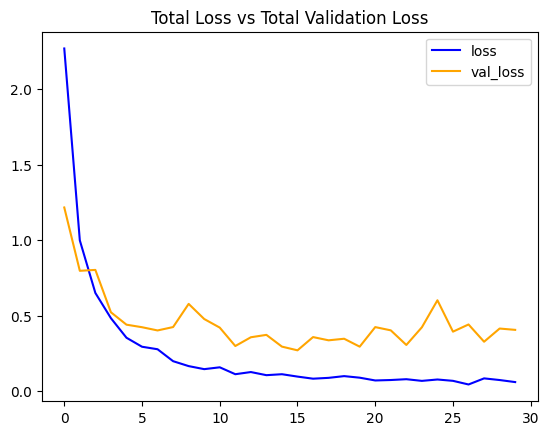

In [16]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

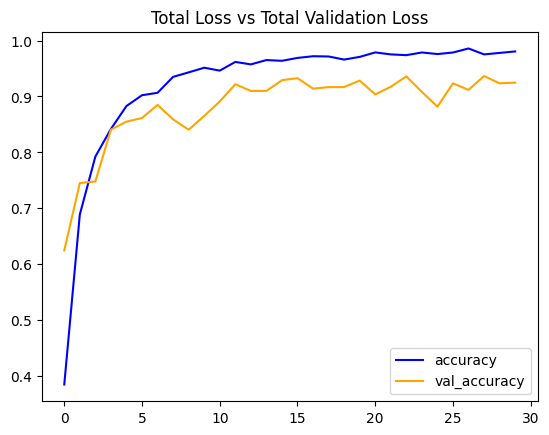

In [17]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

139/139 [==============================] - 0s 3ms/step - loss: 0.4063 - accuracy: 0.9248
Test Accuracy: 0.9247747659683228


In [ ]:
model.save("alphabetModel2.h5")

In [ ]:

# Get predictions from the model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

139/139 [==============================] - 0s 2ms/step


In [ ]:
cm = confusion_matrix(y_test, y_pred)

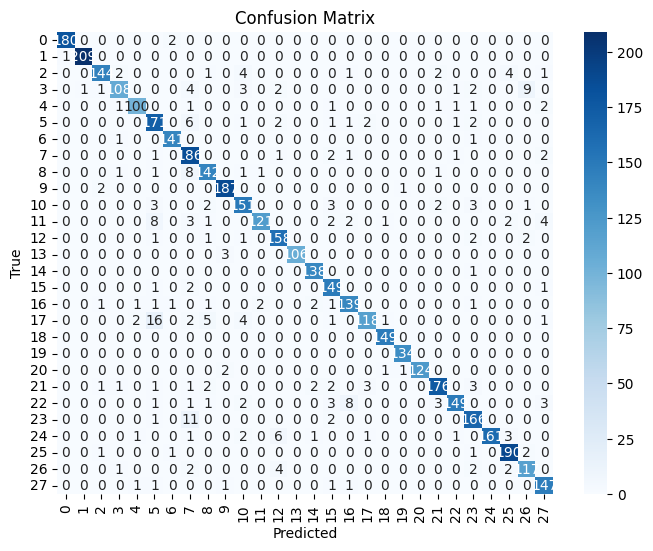

In [ ]:

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Prediction

In [ ]:

# Load the trained model
loaded_model = load_model("/content/alphabetModel2.h5")


In [ ]:
import noisereduce as nr


def preprocess_input(file_path, n_mels=128, hop_length=512, target_size=(128, 32), noise_reduction_strength=0.02, silence_threshold=0.02):
    # Load audio
    y, sr = librosa.load(file_path)

    # Denoise audio
    y_denoised = nr.reduce_noise(y, sr,prop_decrease=noise_reduction_strength)

    # Trim silence
    y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=silence_threshold)

    # Extract and resize log mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y_trimmed, sr=sr, n_mels=n_mels, hop_length=hop_length)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    log_mel_spec_resized = np.resize(log_mel_spec, target_size)

    # Add batch and channel dimensions
    log_mel_spec_resized = log_mel_spec_resized[np.newaxis, ..., np.newaxis]

    return log_mel_spec_resized


In [ ]:
# Function to map encoded labels to original text names
def decode_labels(encoded_labels, label_encoder):
    return label_encoder.inverse_transform(encoded_labels)

In [ ]:
# Example usage for prediction
input_audio_path = "/content/1_6_Taj_Zua_T (1).wav"

In [ ]:
preprocessed_input = preprocess_input(input_audio_path)
prediction = model.predict(preprocessed_input)
predicted_class = np.argmax(prediction)

In [ ]:
predicted_class

2